* 用已经清洗好的数据集
* 使用 LGB/XGB/GBDT
* 预测 12 月销量

* 自2018年1月1日起，小排量乘用车购置税将从目前的7.5%，恢复按10%的法定税率征收。
* 2017-12 月, 因为购置税取消, 很多人抢在 2018-1 月之前, 购买, 提前释放了, 18 年的购买潜力, 造成 12 月销量, 异常波动
* 使得大家各种模型预测极度不准

In [1]:
14406039 / 197343

73.0

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [159]:
data = pd.read_csv('../../raw/LiChuan/DecWindowFeatures.csv')
submit= pd.read_csv('../../raw/CarsSaleForecast/yancheng_testB_20180224.csv')

In [79]:
labels = data['sale_quantity']
data = data.drop(['sale_date', 'class_id', 'sale_quantity'], axis=1)

In [48]:
# 划分测试训练集
train = data[:-140]
test = data[-140:]
labels = labels[:-140]

## LightGBM

In [49]:
# 12 月
lgb_train = lgb.Dataset(train, labels)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.8,
'num_leaves': 35,
'min_data': 20,
'min_hessian': 1,
'verbose': -1,}

model = lgb.train(params, lgb_train, 1200)
lgb_pred = model.predict(test)
# rmsetmp = sp.sqrt(sp.mean((test_labels_1 - lgb_pred_1) ** 2))

# print('This time rmse is: '+ str(rmsetmp_1))

In [50]:
submit['predict_quantity'] = lgb_pred
submit.to_csv('../../raw/LiChuan/result_180225_lightGBM_lastmonth.csv',index=False, header=True)  

In [172]:
labels[-140:].sum()*1.4

77951.719909153981

In [52]:
lgb_pred.sum()

62884.247471946161

## GBDT

In [80]:
data = data.drop(['sale_quantity_last_2M_sum', 'sale_quantity_last_3M_sum', 'sale_quantity_last_6M_sum', 'sale_quantity_last_12M_sum'], axis=1)
data = data.drop(['sale_quantity_last_2M_max', 'sale_quantity_last_3M_max', 'sale_quantity_last_6M_max', 'sale_quantity_last_12M_max'], axis=1)
#data = data.drop(['sale_quantity_last_2M_min', 'sale_quantity_last_3M_min', 'sale_quantity_last_6M_min', 'sale_quantity_last_12M_min'], axis=1)
#data = data.drop(['sale_quantity_last_2M_mean', 'sale_quantity_last_3M_mean', 'sale_quantity_last_6M_mean', 'sale_quantity_last_12M_mean'], axis=1)
data = data.drop(['sale_quantity_last_2M_median', 'sale_quantity_last_3M_median', 'sale_quantity_last_6M_median', 'sale_quantity_last_12M_median'], axis=1)
#data = data.drop(['sale_quantity_last_2M_std', 'sale_quantity_last_3M_std', 'sale_quantity_last_6M_std', 'sale_quantity_last_12M_std'], axis=1)

In [81]:
# 划分测试训练集
train = data[:-140]
test = data[-140:]
labels = labels[:-140]

In [66]:
est = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.008,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=13, min_samples_split=10,
                                   loss='huber').fit(train, labels)

In [68]:
gbdt_pred = est.predict(test)

In [69]:
gbdt_pred.sum()

61456.391666399126

In [71]:
sp.sqrt(sp.mean((gbdt_pred - lgb_pred) ** 2))

64.925790955908198

In [72]:
submit['predict_quantity'] = gbdt_pred
submit.to_csv('../../raw/LiChuan/result_180225_GBDT.csv',index=False, header=True) 

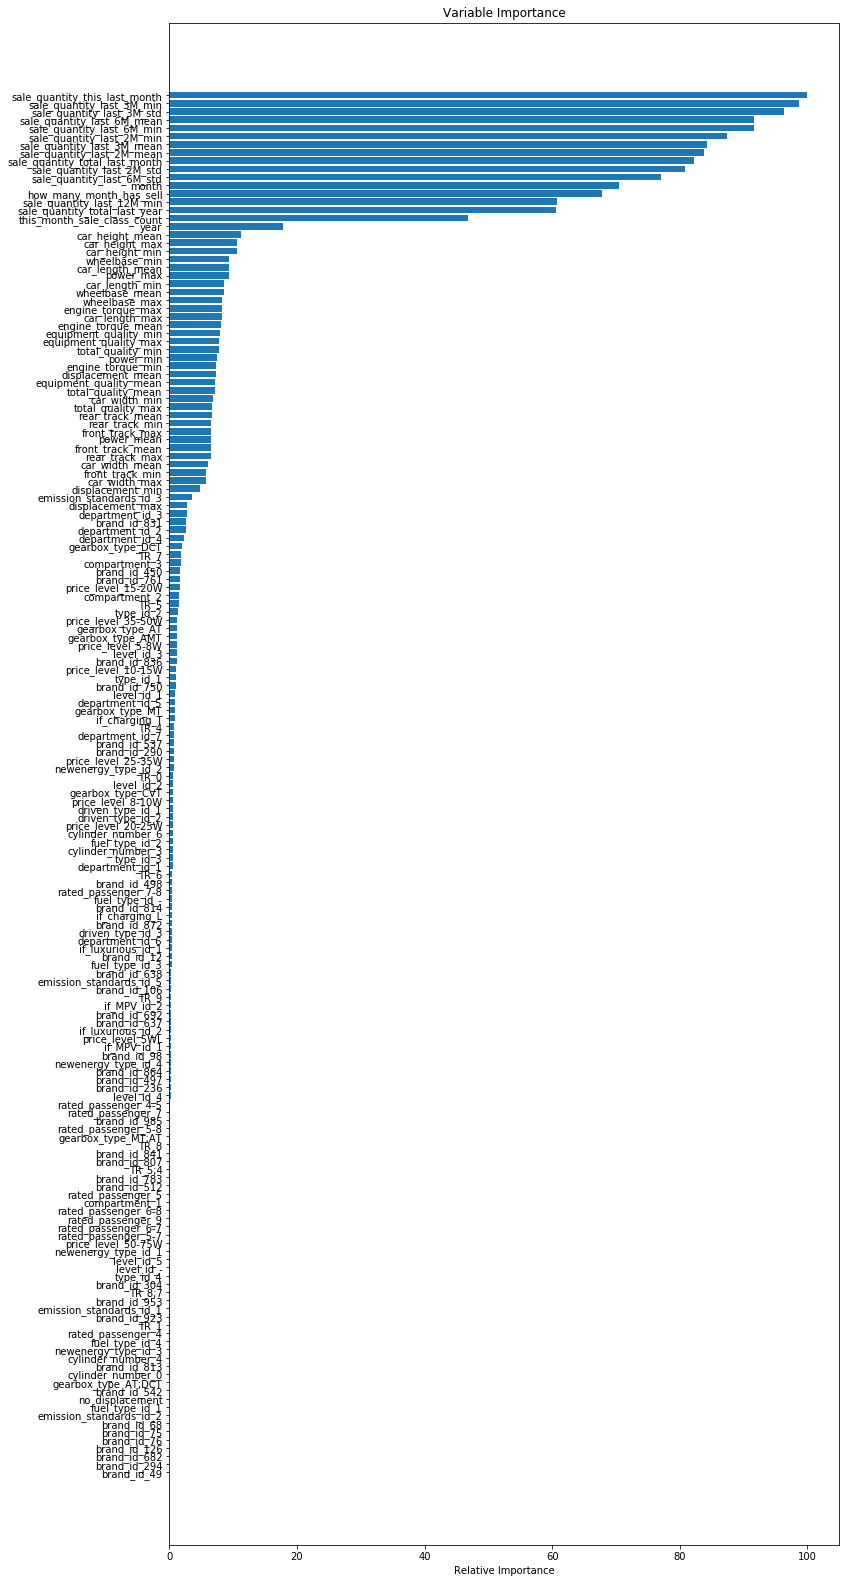

In [119]:
feature_importance = est.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 28))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## XGBoost

In [86]:
trainset = xgb.DMatrix(train, label=labels)
testset = xgb.DMatrix(test)

params = {
    'booster': 'gbtree', # 基于树的模型进行计算
    'objective': 'reg:linear', # 线性回归
    'eval_metric': 'rmse', # RMSE 评价函数
    'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
    'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
    'max_depth': 5, # 树的最大深度。缺省值为6
    'lambda': 10, # L3 正则的惩罚系数
    'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
    'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
    'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
    }
    
model = xgb.train(params, trainset, num_boost_round=3000)
predict_xgb = model.predict(testset)
# rmsetmp = sp.sqrt(sp.mean((test_labels - predict_xgb) ** 2))

# print('This time rmse is: '+ str(rmsetmp))

In [87]:
predict_xgb.sum()

61631.012

In [91]:
sp.sqrt(sp.mean((gbdt_pred - lgb_pred) ** 2))

64.925790955908198

In [89]:
sp.sqrt(sp.mean((predict_xgb - gbdt_pred) ** 2))

101.64707263110986

In [90]:
submit['predict_quantity'] = predict_xgb
submit.to_csv('../../raw/LiChuan/result_180225_XGBoost.csv',index=False, header=True) 

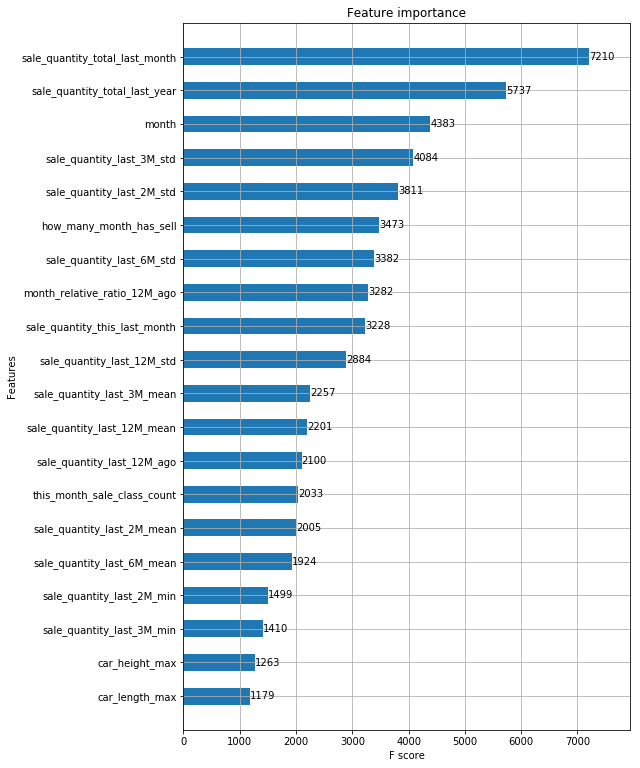

In [138]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

## LSTM

In [120]:
lstm = pd.read_csv('../../raw/LiChuan/result_180226_LSTM.csv')

In [124]:
predict_lstm = lstm['predict_quantity'].values

In [125]:
predict_lstm.sum()

61972.049488288729

In [126]:
sp.sqrt(sp.mean((predict_xgb - predict_lstm) ** 2))

166.42492744225726

In [127]:
sp.sqrt(sp.mean((lgb_pred - predict_lstm) ** 2))

127.28211769888456

In [128]:
sp.sqrt(sp.mean((gbdt_pred - predict_lstm) ** 2))

106.02313988533002

## Baseline

In [150]:
predict_base = test['sale_quantity_this_last_month'].values * 1.5

In [151]:
sp.sqrt(sp.mean((gbdt_pred - predict_base) ** 2))

238.0770861786871

In [152]:
sp.sqrt(sp.mean((lgb_pred - predict_base) ** 2))

245.08144659092596

In [153]:
sp.sqrt(sp.mean((predict_xgb - predict_base) ** 2))

245.42857172052734

In [154]:
sp.sqrt(sp.mean((predict_base - predict_lstm) ** 2))

288.56146017549304

In [158]:
submit['predict_quantity'] = predict_base
submit.to_csv('../../raw/LiChuan/result_180226_Baseline.csv',index=False, header=True) 

## 0226 submit

In [139]:
prediction = predict_xgb * 0.42 + gbdt_pred * 0.58
submit['predict_quantity'] = prediction
submit.to_csv('../../raw/LiChuan/result_180226_XGBoost×0.42_GBDT×0.58.csv',index=False, header=True) 

In [141]:
prediction.sum()

61529.731115180919

In [142]:
sp.sqrt(sp.mean((predict_base - prediction) ** 2))

80.530888446755966

In [143]:
sp.sqrt(sp.mean((prediction - predict_lstm) ** 2))

125.04265726136995

## 将 1.6 T 以下小排量车型乘以系数提交

In [191]:
Nov_pred = data[-280:-140]

In [201]:
Nov_pred.loc[ Nov_pred['displacement_mean'] <=0.3, 'sale_quantity'] = Nov_1

In [233]:
Nov_pred.loc[ Nov_pred['displacement_mean'] > 0.3, 'sale_quantity'] = Nov_2

In [234]:
Nov_pred['sale_quantity'].sum()

82093.609490716801

In [235]:
submit['predict_quantity'] = Nov_pred['sale_quantity'].values
submit.to_csv('../../raw/LiChuan/result_180226_baseline×1.6.csv',index=False, header=True) 

In [226]:
Nov_1 = Nov_pred[Nov_pred['displacement_mean']<=0.3]['sale_quantity'].values*1.5

In [232]:
Nov_2 = Nov_pred[Nov_pred['displacement_mean']>0.3]['sale_quantity'].values*1.1

In [222]:
test.loc[:, 'sale_quantity'] = gbdt_pred

In [224]:
test['sale_quantity']

61456.391666399126

In [227]:
test.loc[ test['displacement_mean'] <=0.3, 'sale_quantity'] = Nov_1

In [195]:
Nov_pred[Nov_pred['displacement_mean']<=0.3]['sale_quantity'] = 1

In [197]:
Nov_pred['sale_quantity']

55679.799935109986

## 研究 B榜 290

In [ ]:
raw/Woody/result_180226_gbdt_big_quantity*1.5.csv

In [237]:
big_quantity = pd.read_csv('../../raw/Woody/result_180226_gbdt_big_quantity*1.5.csv')

In [243]:
big_pred = big_quantity['predict_quantity'].values

In [244]:
sp.sqrt(sp.mean((gbdt_pred - big_pred) ** 2))

189.00258366405183